**Predictive Lead Scoring**

# import useful libraries and Load the data

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

In [2]:
sys.path.append("..")
data_dir = Path('../data/') 
modules_dir = Path('../modules/')

> The dataset: https://www.kaggle.com/arashnic/banking-loan-prediction

**The content of the dataset**
- ID : Unique Customer ID
- Gender : Gender of the applicant
- DOB : Date of Birth of the applicant
- LeadCreationDate : Date on which Lead was created
- City_Code : Anonymised Code for the City
- City_Category: Anonymised City Feature
- Employer_Code: Anonymised Code for the Employer
- Employer_Category1 : Anonymised Employer Feature
- Employer_Category2: Anonymised Employer Feature
- Monthly_Income : Monthly Income in Dollars
- CustomerExistingPrimaryBankCode : Anonymised Customer Bank Code
- PrimaryBankType: Anonymised Bank Feature
- Contacted: Contact Verified (Y/N)
- Source : Categorical Variable representing source of lead
- Source_Category: Type of Source
- Existing_EMI : EMI of Existing Loans in Dollars
- Loan_Amount: Loan Amount Requested
- Loan_Period: Loan Period (Years)
- Interest_Rate: Interest Rate of Submitted Loan Amount
- EMI: EMI of Requested Loan Amount in dollars
- Var1: Anonymized Categorical variable with multiple levels
- Approved: (Target) Whether a loan is Approved or not (1-0) . Customer is Qualified Lead or not (1-0)

In [3]:
train = pd.read_csv(data_dir/'train.csv')

In [4]:
test = pd.read_csv(data_dir/'test.csv')

# Data Wrangling

## Data exploring

**samples**

In [5]:
train.sample(3)

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
54865,APPW80751241224,Female,09/05/88,14/09/16,NaN,NaN,NaN,NaN,NaN,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
7927,APPA40143687637,Female,01/12/86,12/07/16,C10002,A,COM0003194,A,4.0,2770.0,...,Y,S133,C,0.0,32000.0,3.0,18.25,1161.0,4,0
24788,APPZ30652776917,Female,23/01/90,04/08/16,C10011,B,COM0014696,A,4.0,1050.0,...,N,S159,C,0.0,NaN,NaN,NaN,NaN,0,0


In [6]:
test.sample(3)

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1
4158,APPL50227253315,Male,03/03/77,01/09/16,C10004,A,COM0000089,B,2.0,2000.0,...,P,Y,S122,G,200.0,39000.0,5.0,NaN,NaN,4
5575,APPX30411223341,Male,03/12/84,19/09/16,C10002,A,COM0002072,B,4.0,13200.0,...,P,Y,S122,G,0.0,150000.0,5.0,15.25,3588.0,10
5466,APPX70783916336,Male,06/04/92,18/09/16,C10002,A,COM0000226,C,4.0,2200.0,...,P,Y,S122,G,0.0,37000.0,4.0,16.75,1063.0,4


**target and features**

- Our target is the column **Approved** from the train table: it consists of 0 if the loan default exist and the loan is not approved and 1 if not.
- The remaining columns 21 will be considered as features and after a statistical analysis we will selected only the best ones.

**size and shape**

In [7]:
train.shape

(69713, 22)

In [8]:
test.shape

(30037, 21)

> Let us perform all our operation on train data and create a modular code for the test dataset and futures tests 

**missing values and types of columns**

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   69713 non-null  object 
 1   Gender                               69713 non-null  object 
 2   DOB                                  69698 non-null  object 
 3   Lead_Creation_Date                   69713 non-null  object 
 4   City_Code                            68899 non-null  object 
 5   City_Category                        68899 non-null  object 
 6   Employer_Code                        65695 non-null  object 
 7   Employer_Category1                   65695 non-null  object 
 8   Employer_Category2                   65415 non-null  float64
 9   Monthly_Income                       69713 non-null  float64
 10  Customer_Existing_Primary_Bank_Code  60322 non-null  object 
 11  Primary_Bank_Type           

> This helps us understand the data columns: 22
>- the DOB and Lead_creation_date are in wrong format : they should be datetime
>- Multiple columns have null values even if we are lucky to have all our target.

**number of unique values**

In [10]:
train.nunique().sort_values()

Approved                                   2
Gender                                     2
Contacted                                  2
Primary_Bank_Type                          2
City_Category                              3
Employer_Category1                         3
Employer_Category2                         4
Var1                                       5
Loan_Period                                6
Source_Category                            7
Source                                    29
Customer_Existing_Primary_Bank_Code       57
Interest_Rate                             72
Lead_Creation_Date                        92
Loan_Amount                              196
City_Code                                678
EMI                                     2179
Existing_EMI                            3245
Monthly_Income                          5010
DOB                                    10759
Employer_Code                          36617
ID                                     69713
dtype: int

> We can observe that almost all variable are Categorical because they have less unique values

## Data Cleaning

**mistype**

In [11]:
# Changing DOB and lead creation date to the appropriate type
def handle_datetime(data):
    data.DOB = data.DOB.astype('datetime64')
    data.Lead_Creation_Date = data.Lead_Creation_Date.astype('datetime64')
    return data

In [12]:
clean_train = handle_datetime(train)

> we could have parsed those columns to datetime while reading with pandas.

**missing values**

In [13]:
pd.concat([train.isnull().sum().sort_values(),train.isnull().sum().sort_values()/train.shape[0]], axis=1)\
                        .rename(columns={0:'count', 1:'percentage'})

,count,percentage
ID,0,0.000000
Source_Category,0,0.000000
Source,0,0.000000
Contacted,0,0.000000
Var1,0,0.000000
Monthly_Income,0,0.000000
Approved,0,0.000000
Lead_Creation_Date,0,0.000000
Gender,0,0.000000
DOB,15,0.000215


train.Existing_EMI

Our first strategy is to keep all the observation.
- For the missing date of birth we will first convert the date to age and then use the median to replace the null value.
- Since most of those columns are categorical, we will create a category "unknown" where the value is missing.
- For numerical columns ( Loan Amount, load period, interest rate, existing EMI and EMI ) , we will use different approach. We will assume that if there is no load amount/ period then it is 0 there and the client doesn't have any loan

In [14]:
from datetime import date

def handle_missing_val(data):
    #categorical
    
    # First let us create age columns instead of DOB so that we can replace by median
    data['age'] = data.DOB.apply(lambda x : np.abs(date.today().year - x.year))
    #todo create a column for lead creation date age!!!!!
    data['lead_age'] = data.Lead_Creation_Date.apply(lambda x : np.abs(date.today().year - x.year))
    # drop the DOB columns
    data = data.drop(columns=['DOB','Lead_Creation_Date'])
    # Replacing the missing age with median
    data['age'] = data.age.fillna(data.age.median())
    
    # Replacing the other cat value with "unknown"
    cols_cat = ['City_Category', 'City_Code', 'Employer_Category1',
          'Employer_Code', 'Employer_Category2', 'Primary_Bank_Type',
          'Customer_Existing_Primary_Bank_Code']
    data[cols_cat] = data[cols_cat].fillna("unknown")
    
    # Now handle the num cols
    cols_num = ['Existing_EMI', 'Loan_Amount', 'Loan_Period', 'Interest_Rate', 'EMI']
    data[cols_num] = data[cols_num].fillna(0)
    
    return data

In [15]:
clean_train = handle_missing_val(clean_train)

In [16]:
clean_train.isnull().sum()

ID                                     0
Gender                                 0
City_Code                              0
City_Category                          0
Employer_Code                          0
Employer_Category1                     0
Employer_Category2                     0
Monthly_Income                         0
Customer_Existing_Primary_Bank_Code    0
Primary_Bank_Type                      0
Contacted                              0
Source                                 0
Source_Category                        0
Existing_EMI                           0
Loan_Amount                            0
Loan_Period                            0
Interest_Rate                          0
EMI                                    0
Var1                                   0
Approved                               0
age                                    0
lead_age                               0
dtype: int64

In [17]:
# save the data
# clean_train.to_csv(data_dir/'clean_train.csv', index=False)

# EDA

## Feature distributions

> We will display only for relevant columns. Id columns for example seems not relevant

In [18]:
feature_list = clean_train.drop(columns='Approved').columns
target = ['Approved']

cat_cols = ['Gender', 'City_Code', 'City_Category','Employer_Code', 'Employer_Category1', 'Employer_Category2',
       'Customer_Existing_Primary_Bank_Code', 'Primary_Bank_Type', 'Contacted', 'Source', 'Source_Category',
       'Var1']
num_cols = ['age','lead_age', 'Monthly_Income', 'Existing_EMI', 'Loan_Amount', 'Loan_Period', 'Interest_Rate', 'EMI']

**Bar plot of the categorical features:**

In [19]:
# Let us have a look again at the distinct values
clean_train[cat_cols].nunique().sort_values()

Gender                                     2
Contacted                                  2
Primary_Bank_Type                          3
City_Category                              4
Employer_Category1                         4
Employer_Category2                         5
Var1                                       5
Source_Category                            7
Source                                    29
Customer_Existing_Primary_Bank_Code       58
City_Code                                679
Employer_Code                          36618
dtype: int64

> **Employer code, City_Code and Customer_Existing_Primary_Bank_code**
>
> For these columns we will display only the top 20 values since the number of distincts values is huge

In [20]:
def plot_top20(df, col):
    stats = df[[col, 'Approved']].groupby(col).agg(['count'])
    stats = stats.reset_index()
    stats.columns = [col, 'count']
    stats = stats.sort_values('count', ascending=False)
    fig = plt.subplots(figsize=(15,4))
    plt.bar(stats[col].astype(str).values[0:20], stats['count'].values[0:20])
    plt.xticks(rotation='vertical')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.title('Top20 ' + col + 's based on frequency')

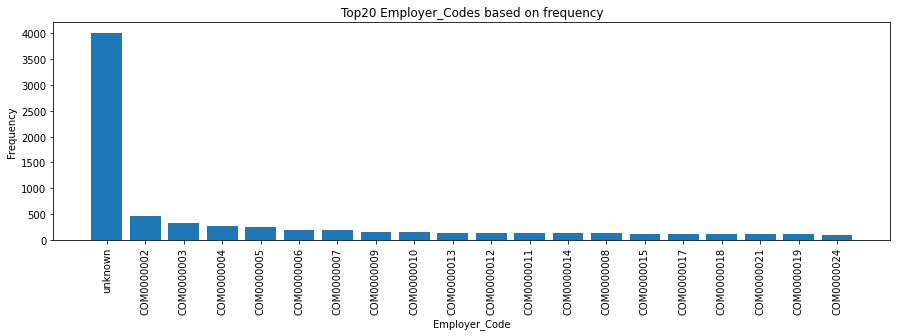

In [21]:
plot_top20(clean_train,'Employer_Code')

In [22]:
cat_cols.remove('Employer_Code')

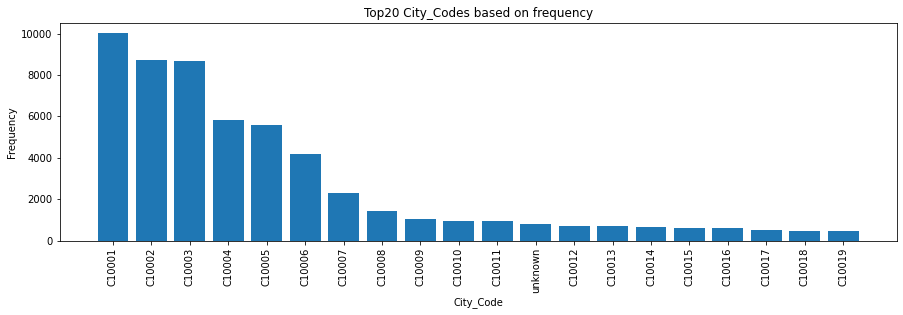

In [23]:
plot_top20(clean_train, 'City_Code')

In [24]:
cat_cols.remove('City_Code')

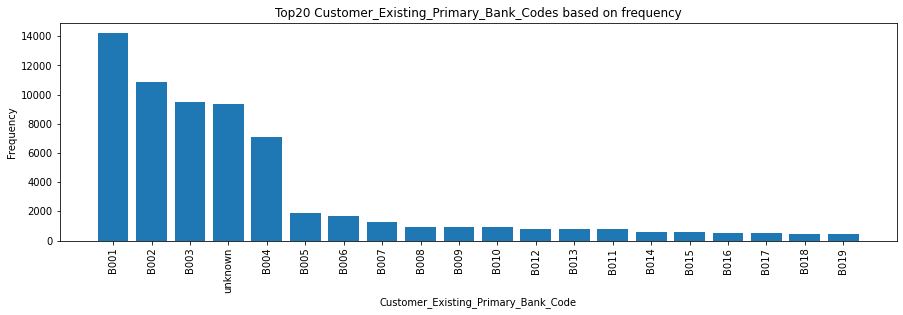

In [25]:
plot_top20(clean_train, 'Customer_Existing_Primary_Bank_Code')

In [26]:
cat_cols.remove('Customer_Existing_Primary_Bank_Code')

> For the other let us display the bar plot

In [27]:
cat_cols

['Gender',
 'City_Category',
 'Employer_Category1',
 'Employer_Category2',
 'Primary_Bank_Type',
 'Contacted',
 'Source',
 'Source_Category',
 'Var1']

In [28]:
def annotate_pct(ax):
    '''
    This function annotate bar plot by adding the count on each bar
    '''
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')

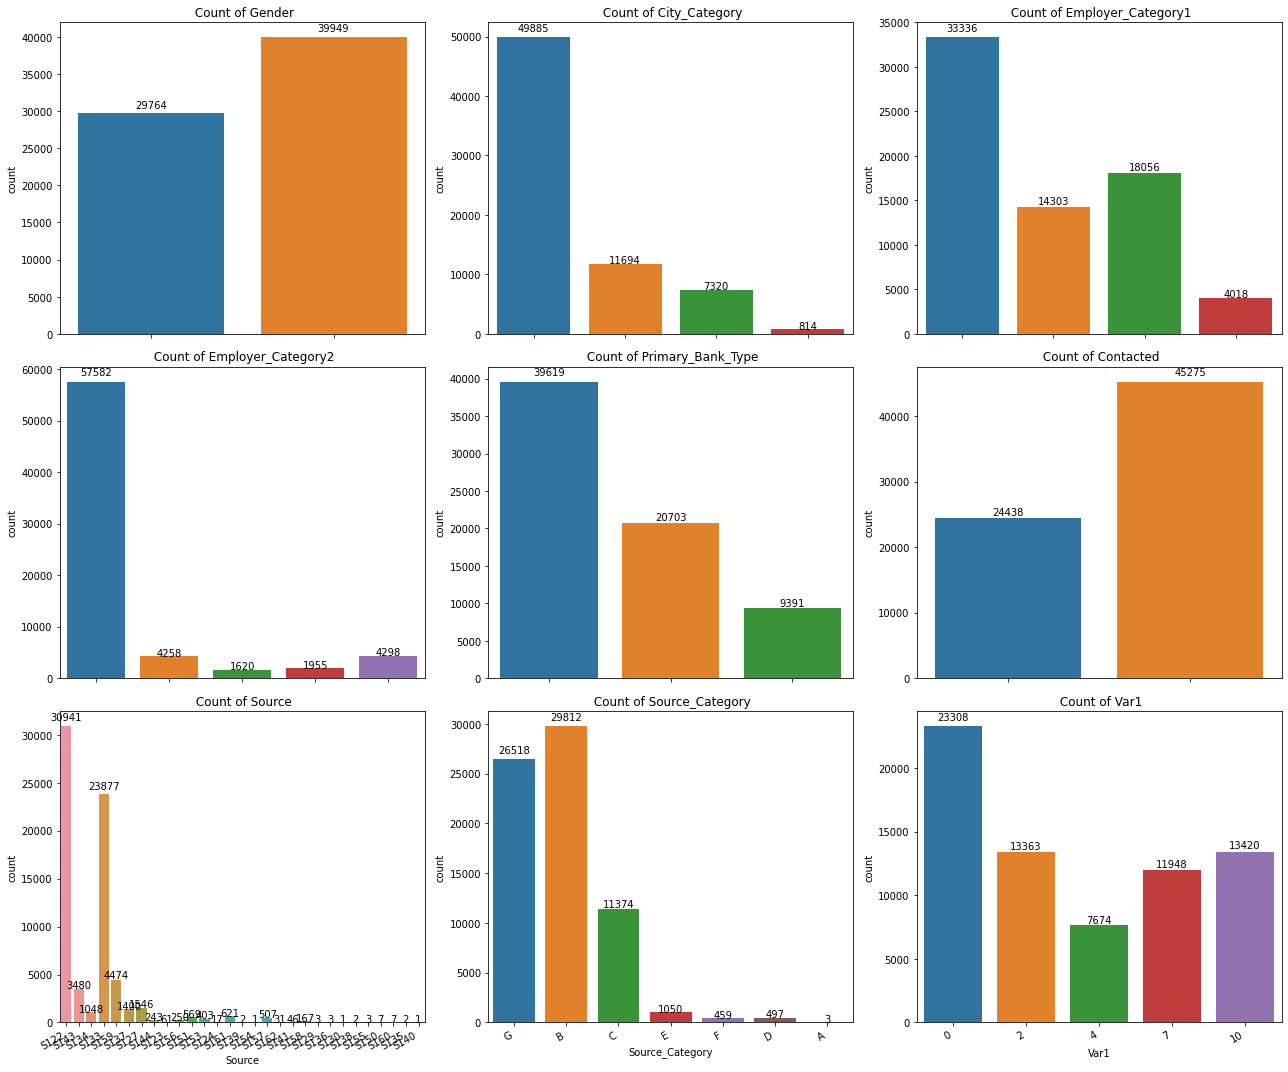

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,15))
i,j=0,0
for cols_name in cat_cols:
    sns.countplot(x=cols_name, data = clean_train, ax = axes[i,j])
    annotate_pct(axes[i, j])
    axes[i, j].set_title(' Count of '+str(cols_name))
    j+=1
    if j%3 == 0:
        i+=1
        j=0
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**Histograms of the numerical features:**

In [30]:
num_cols

['age',
 'lead_age',
 'Monthly_Income',
 'Existing_EMI',
 'Loan_Amount',
 'Loan_Period',
 'Interest_Rate',
 'EMI']

C:\Users\vivie\.conda\envs\dsaproject\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


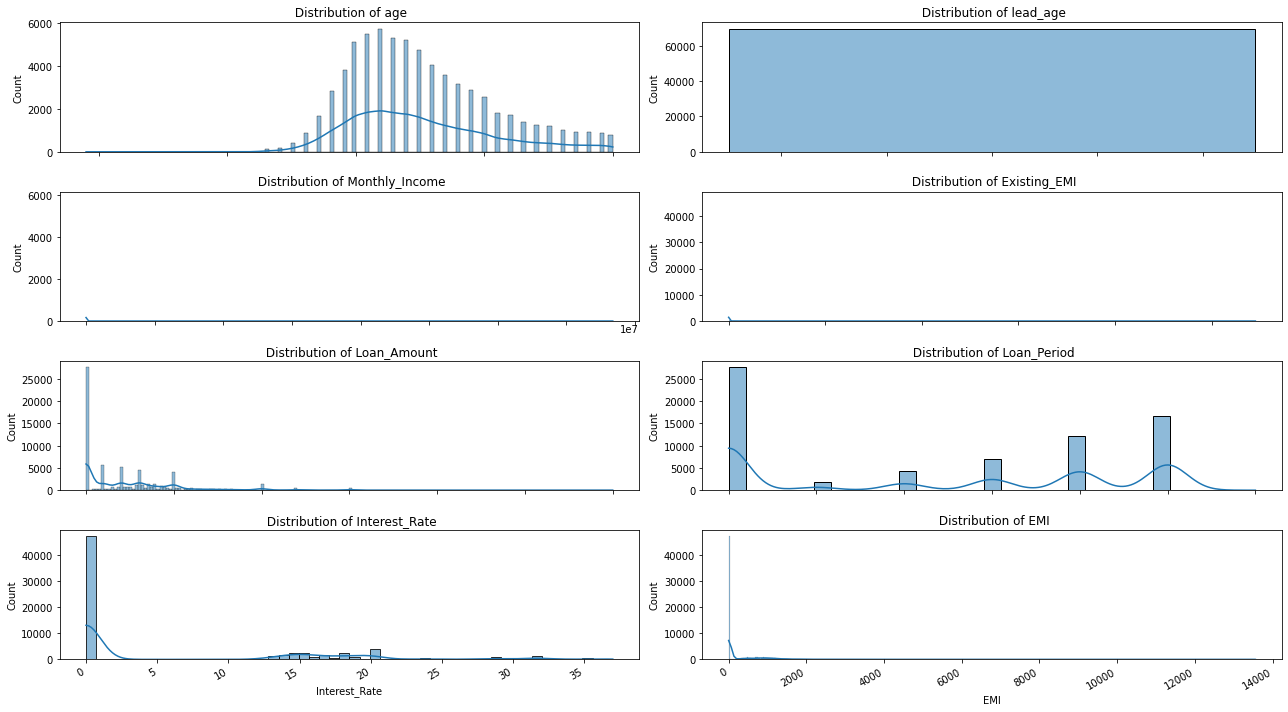

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,10))
i,j=0,0
for cols_name in num_cols:
    sns.histplot(x=cols_name, data = clean_train, ax = axes[i,j], kde= True)
    axes[i, j].set_title(' Distribution of '+str(cols_name))
    j+=1
    if j%2 == 0:
        i+=1
        j=0
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


## Target distribution

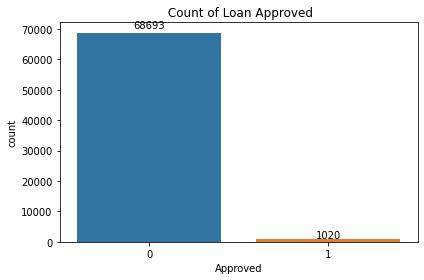

In [32]:
# And the target
fig, ax = plt.subplots()
sns.countplot(x=target[0], data = clean_train, ax=ax)
annotate_pct(ax)
ax.set_title(' Count of Loan Approved')
plt.tight_layout()
plt.show()

## Relations : Features multicollinearity, relation between target and features

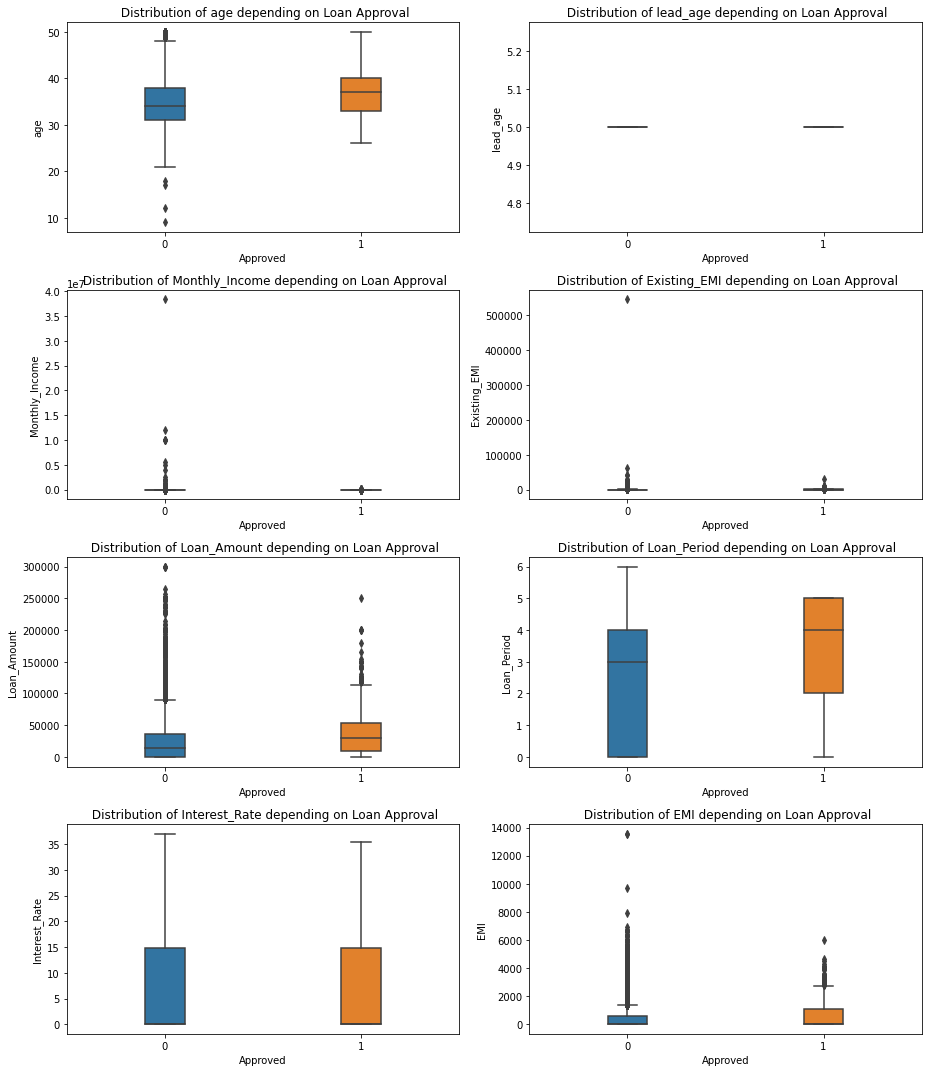

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13,15))
i,j=0,0
for cols_name in num_cols:
#     sns.kdeplot(data=clean_train, x=cols_name, hue=target[0], ax= axes[i,j])

    sns.boxplot(y=cols_name, x=target[0], data = clean_train, width = 0.2, ax = axes[i,j])
    axes[i, j].set_title(' Distribution of '+str(cols_name)+' depending on Loan Approval')
    j+=1
    if j%2 == 0:
        i+=1
        j=0

# sns.despine(left=True)

plt.tight_layout()
plt.show()